In [2]:
import sagemaker

# S3 bucket and prefix
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'exercises/train-on-multiple-instances/DEMO-data-distribution-types'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [3]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import io
import time
import copy
import json
import sys
import sagemaker.amazon.common as smac
import os

In [4]:
def get_gdelt(filename):
    s3 = boto3.resource('s3')
    s3.Bucket('gdelt-open-data').download_file('events/' + filename, '.gdelt.csv')
    df = pd.read_csv('.gdelt.csv', sep='\t')
    header = pd.read_csv('https://www.gdeltproject.org/data/lookups/CSV.header.historical.txt', sep='\t')
    df.columns = header.columns
    return df

In [5]:
data = get_gdelt('1979.csv')
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED
0,1,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
1,2,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
2,3,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,106.3590,-1903584,4.0,"Dizhou, Guangxi, China",CH,CH16,23.0036,106.3590,-1903584.0,20130203
3,4,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,-96.8067,1380944,3.0,"Dallas, Texas, United States",US,USTX,32.7831,-96.8067,1380944.0,20130203
4,5,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,34.6809,-779676,4.0,"Emunim, HaDarom, Israel",IS,IS01,31.7444,34.6809,-779676.0,20130203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430935,230397975,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430936,230397976,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430937,230397977,19791231,197912,1979,1979.9890,USA,WASHINGTON,USA,NaN,NaN,...,65.0000,-2089022,4.0,"Moscow, Moskva, Russia",RS,RS48,55.7522,37.6156,-2960561.0,20130206
430938,230397978,19791231,197912,1979,1979.9890,VNM,VIETNAM,VNM,NaN,NaN,...,0.0000,0,1.0,France,FR,FR,46.0000,2.0000,0.0,20130206


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


col_0,% observations
EventCode,
10,0.060275
11,0.001703
12,0.013786
13,0.014074
14,0.006790
...,...
1821,0.000223
1822,0.000601
1823,0.000079


,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Lat,Actor2Geo_Long
count,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000
mean,4.369694,5.127215,26.311911,26.111038,23.109048,23.637813
std,3.121310,2.637798,21.865323,61.125843,22.136466,57.693612
min,1.000000,0.000000,-85.622100,-179.050000,-85.622100,-179.050000
25%,2.000000,3.333333,10.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,32.000000,28.229400,30.044500,19.500000
75%,6.000000,6.666667,40.400000,53.000000,39.928900,50.093800
max,54.000000,28.571429,85.000000,180.000000,85.000000,180.000000


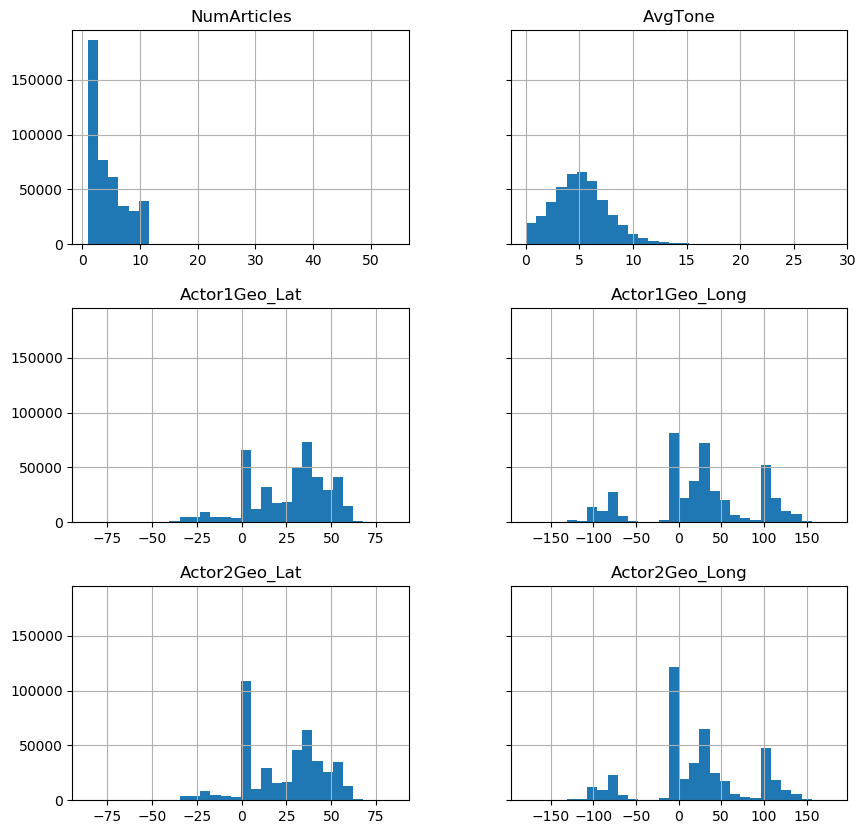

In [6]:
data = data[['EventCode', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
data['EventCode'] = data['EventCode'].astype(object)

for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

display(data.describe())
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))
plt.show()

In [7]:
events = pd.crosstab(index=data['EventCode'], columns='count').sort_values(by='count', ascending=False).index[:20]

## Similarly doing for other years

In [8]:
def write_to_s3(bucket, prefix, channel, file_prefix, X, y):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'), y.astype('float32'))
    buf.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, channel, file_prefix + '.data')).upload_fileobj(buf)

def transform_gdelt(df, events=None):
    df = df[['AvgTone', 'EventCode', 'NumArticles', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
    df['EventCode'] = df['EventCode'].astype(object)
    if events is not None:
        df = df[np.in1d(df['EventCode'], events)]
    return pd.get_dummies(df[((df['Actor1Geo_Lat'] == 0) & (df['Actor1Geo_Long'] == 0) != True) &
                                   ((df['Actor2Geo_Lat'] == 0) & (df['Actor2Geo_Long'] == 0) != True)])
    
def prepare_gdelt(bucket, prefix, file_prefix, events=None, random_state=1729):
    df = get_gdelt(file_prefix + '.csv')
    model_data = transform_gdelt(df, events)
#    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).as_matrix(), 
#                                           [int(0.9 * len(model_data))])
    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).values, 
                                           [int(0.9 * len(model_data))])

    write_to_s3(bucket, prefix, 'train', file_prefix, train_data[:, 1:], train_data[:, 0])
    write_to_s3(bucket, prefix, 'validation', file_prefix, validation_data[:, 1:], validation_data[:, 0])

In [9]:
for year in range(1979, 1984):
    prepare_gdelt(bucket, prefix, str(year), events)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [10]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}
container = containers[boto3.Session().region_name]

In [16]:
common_training_params = {
    "RoleArn": role,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 2,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix)
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key"  # "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "25",
        "mini_batch_size": "500",
        "predictor_type": "regressor",
        "epochs": "2",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

In [17]:
sharded_job = 'DEMO-linear-sharded-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", sharded_job)

sharded_training_params = copy.deepcopy(common_training_params)
sharded_training_params['TrainingJobName'] = sharded_job
sharded_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'

Job name is: DEMO-linear-sharded-2022-10-03-10-53-09


In [18]:
replicated_job = 'DEMO-linear-replicated-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", replicated_job)

replicated_training_params = copy.deepcopy(common_training_params)
replicated_training_params['TrainingJobName'] = replicated_job
replicated_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'FullyReplicated'

Job name is: DEMO-linear-replicated-2022-10-03-10-53-09


In [19]:
%%time

region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')

sm.create_training_job(**sharded_training_params)
sm.create_training_job(**replicated_training_params)

status = sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=replicated_job)
status = sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=replicated_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 185 ms, sys: 14.5 ms, total: 200 ms
Wall time: 8min 2s


In [20]:
print('Sharded:', sm.describe_training_job(TrainingJobName=sharded_job)['TrainingJobStatus'])
print('Replicated:', sm.describe_training_job(TrainingJobName=replicated_job)['TrainingJobStatus'])

Sharded: Completed
Replicated: Completed
